# Vorlesung 02 - Einführung in die Sprachmodellierung

**Aufgabenbstellung:** Generiere neue Vornamen, die es bisher so noch nicht gibt. 

In [17]:
%pip install torch
import torch

In [3]:
# Einlesen der Namen und speichern in einer Namensliste
lines = open("data/vornamenstatistik_24.csv", "r", encoding="utf-8").read().splitlines()
names = list(set([n.split(",")[1] for n in lines][1:]))
names[:3] #Ausgabe der ersten drei Namen

['Sultan', 'Kaya', 'Levin']

Schritt 1 - Datenanalyse. Was sind die merkmale von Vornamen?

In [4]:
# Sortieren der Namen nach ihrer Länge
sorted_names = sorted(names, key = lambda x: len(x))
sorted_names[:3]

['Io', 'Ai', 'My']

In [5]:
# Kürzester Name
len(sorted_names[1])

2

In [6]:
# Längster Name
len(sorted_names[-1])

17

In [8]:
# Ausgabe der längsten bzw kürzesten Namen
min_len = 2
max_len = 17
print([n for n in sorted_names if len(n) == max_len])

['Anastasia-Isabell']


In [9]:
# Wie lang ist ein Durschnittlicher Name? Da Namen immer eine ganzzahlige Länge haben, bietet sich hier der Median an
from statistics import median
median([len(n) for n in names])

5.0

In [11]:
# Zählen der Buchstaben-Häufigkeiten
buchstaben = {}
buch_ind = {} # hier legen wir uns eine Liste mit dem Index an - diesen brauchen wir später für das Einfügen in die Matrix
ind = 0
for n in names:
    char = ["<s>"] + list(n) + ["<e>"] # <s> und <e> sind spezielle Tokens, die wir uns anlegen, damit wir den Wortanfang und das Wortende modellieren können. 
    for c in char: 
        low_c = c.lower()
        if low_c not in buchstaben:
            buchstaben[low_c] = 0
            buch_ind[low_c] = ind
            ind += 1
        buchstaben[low_c] += 1
buchstaben

{'<s>': 2964,
 's': 721,
 'u': 435,
 'l': 1354,
 't': 568,
 'a': 2880,
 'n': 1481,
 '<e>': 2964,
 'k': 317,
 'y': 386,
 'e': 1632,
 'v': 290,
 'i': 1719,
 'r': 991,
 'b': 187,
 'c': 266,
 'h': 527,
 'd': 477,
 'm': 807,
 'o': 911,
 'z': 119,
 'f': 208,
 'j': 271,
 'ö': 7,
 '-': 101,
 'g': 166,
 'x': 32,
 'p': 139,
 'w': 87,
 'è': 4,
 'é': 35,
 'q': 15,
 'ä': 4,
 'á': 13,
 'ú': 2,
 'ễ': 1,
 'ñ': 1,
 'ș': 1,
 'ë': 7,
 'â': 6,
 'ï': 6,
 'ì': 8,
 'ā': 1,
 'č': 15,
 'ł': 2,
 'ó': 8,
 'ọ': 1,
 'í': 5,
 'ả': 3,
 'ş': 2,
 'ž': 1,
 'à': 2,
 'ü': 2,
 'ç': 1,
 'đ': 4,
 'ự': 1,
 'ơ': 4,
 'ê': 4,
 'ă': 1,
 'ứ': 1,
 'ù': 1,
 'ũ': 1,
 'ư': 4,
 'ò': 1,
 'š': 1,
 'ậ': 1,
 'ạ': 1,
 "'": 1,
 'ờ': 1}

Wir sehen hier im Output, dass wir einige Buchstaben haben, die nur sehr selten vorkommen in unseren Namen. Deswegen filtern wir jetzt alle Buchstaben heraus, die weniger als 10 mal in unserem Datensatz vorkommen.

In [14]:
frequent_chars = [i for i in buchstaben.keys() if buchstaben[i] >= 10]
frequent_chars

['<s>',
 's',
 'u',
 'l',
 't',
 'a',
 'n',
 '<e>',
 'k',
 'y',
 'e',
 'v',
 'i',
 'r',
 'b',
 'c',
 'h',
 'd',
 'm',
 'o',
 'z',
 'f',
 'j',
 '-',
 'g',
 'x',
 'p',
 'w',
 'é',
 'q',
 'á',
 'č']

Schritt 2: Als nächstes wollen wir uns Buchstabenkombinationen anschauen. Dazu speichern wir uns zunächst die Häufigkeiten von Buchstabenpaaren.
Im nächsten Schritt wollen wir dann die Häufigkeiten nutzen, um statistisch einen nächstbesten Buchstaben in unserer Namens-Generierung auszuwählen.

In [69]:
buchstaben_paare = {}
buch_ind = {"<s>": 0, "<e>": 1}
buch_ind_rev = {0: "<s>", 1: "<e>"} # Dieses dict ermöglicht es uns nachher einfacher einen Buchsaben basierend auf seinem Index herauszufinden

ind = 2
for n in names:
    char = ["<s>"] + list(n) + ["<e>"]
    for c1, c2 in zip(char, char[1:]): 
        if c1 in frequent_chars and c1 not in buch_ind: # wir füllen unsere index-Liste neu, damit wir nur die häufigen Buchstaben abbilden
            buch_ind[c1] = ind
            buch_ind_rev[ind] = c1
            ind += 1
        if c1 in frequent_chars and c2 in frequent_chars:
            bigram = (c1.lower(), c2.lower())
            buchstaben_paare[bigram] = buchstaben_paare.get(bigram, 0) + 1
buch_ind

{'<s>': 0,
 '<e>': 1,
 'u': 2,
 'l': 3,
 't': 4,
 'a': 5,
 'n': 6,
 'y': 7,
 'e': 8,
 'v': 9,
 'i': 10,
 's': 11,
 'r': 12,
 'b': 13,
 'h': 14,
 'c': 15,
 'o': 16,
 'z': 17,
 'd': 18,
 'm': 19,
 'j': 20,
 '-': 21,
 'g': 22,
 'x': 23,
 'f': 24,
 'w': 25,
 'k': 26,
 'p': 27,
 'é': 28,
 'q': 29,
 'á': 30,
 'č': 31}

In [74]:
# Um das ganze etwas übersichtlicher darzustellen und besser damit weiter arbeiten zu können, wandeln wir unser dict mit den Buchstaben-Häufigkeitsparen als nächstes in eine Matrix um.
# Wir nutzen Torch für die Matrix.

import torch
BT = torch.zeros(len(frequent_chars), len(frequent_chars))

for n in names:
    char = ["<s>"] + list(n) + ["<e>"]
    for c1, c2 in zip(char, char[1:]): 
        if c1.lower() in frequent_chars and c2.lower() in frequent_chars:
            ind_x = buch_ind[c1.lower()]
            ind_y = buch_ind[c2.lower()]
            BT[ind_x, ind_y] += 1
BT

tensor([[ 0.,  0., 16.,  ...,  8.,  2.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 35.,  1.,  ...,  1.,  0.,  0.],
        ...,
        [ 0.,  0., 11.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0., 15.,  0.,  ...,  0.,  0.,  0.]])

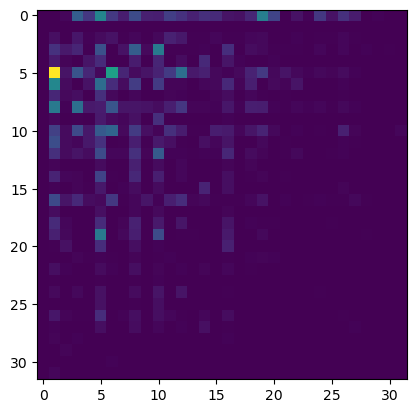

In [75]:
import matplotlib.pyplot as plt
plt.imshow(BT)

Die obere Darstellung ist noch nicht sehr gut zu interpretieren - deswegen erweitern wir sie uns jetzt so, dass wir die Buchstabenkombinationen und ihre Häufigkeit einfach ablesen können.

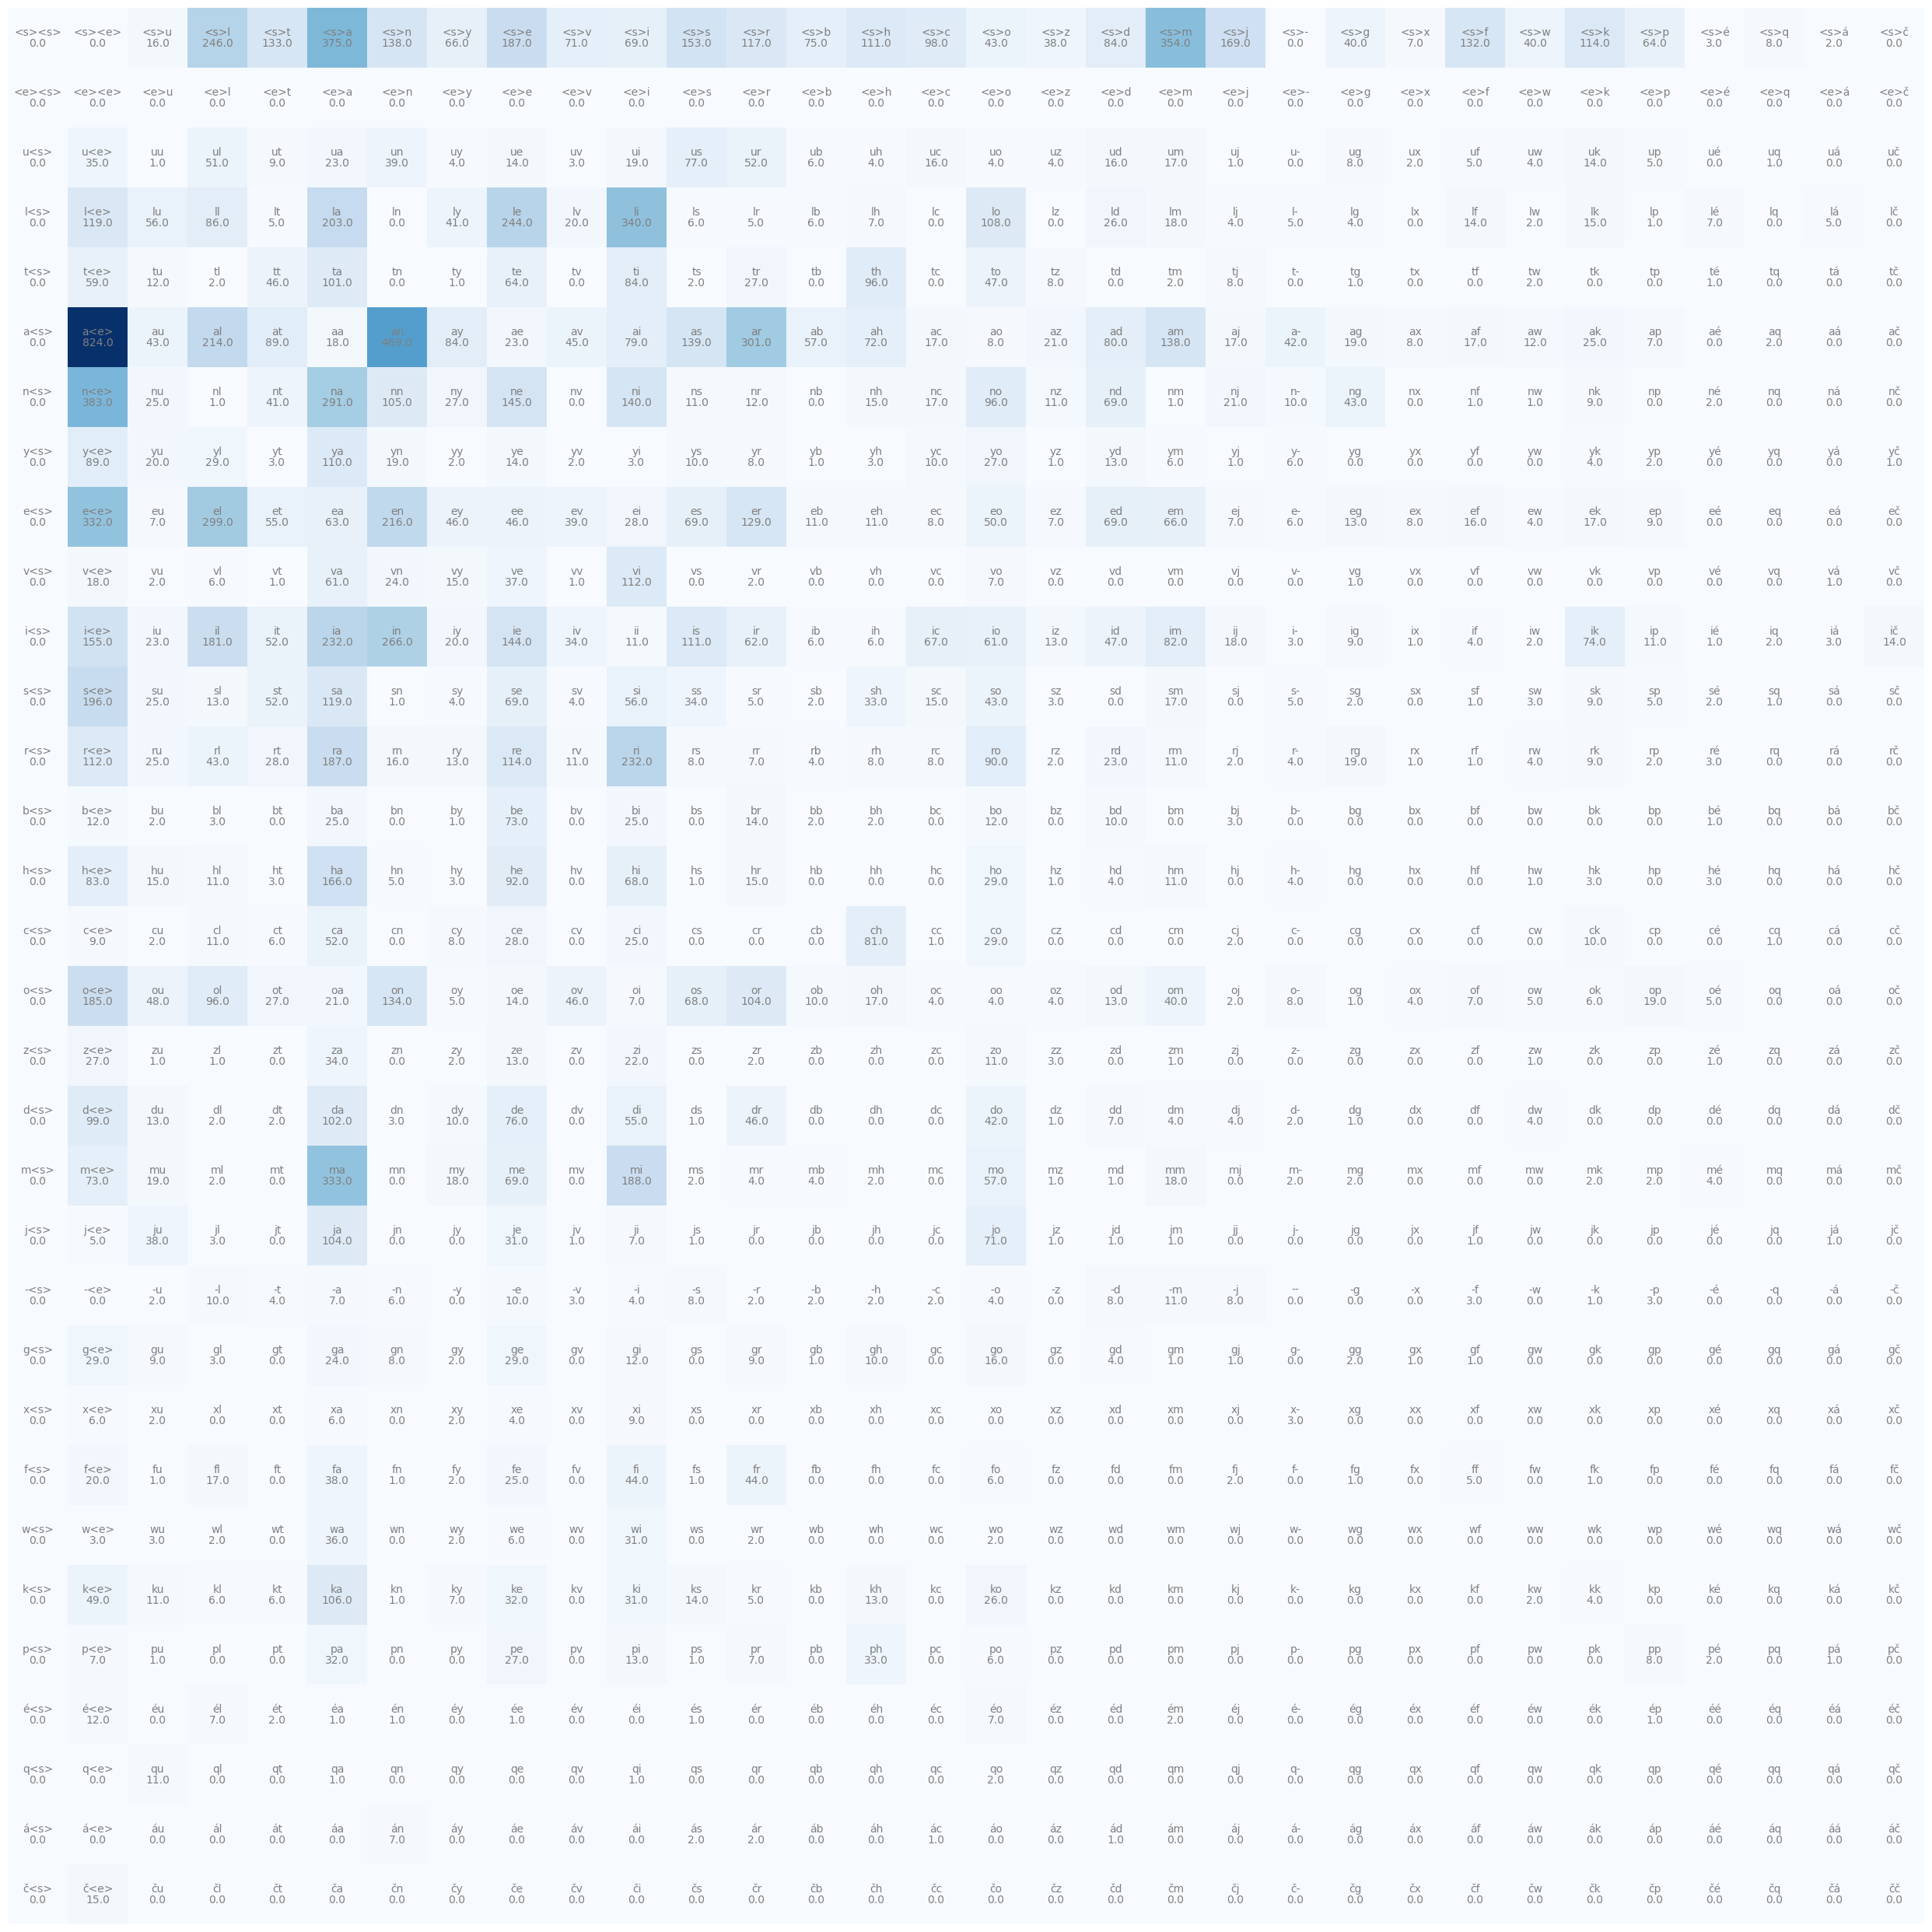

In [76]:
plt.figure(figsize=(32,32))
plt.imshow(BT, cmap='Blues')
for i in range(len(frequent_chars)):
    for j in range(len(frequent_chars)):
        chstr = buch_ind_rev[i] + buch_ind_rev[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, BT[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

Schritt 3: Bevor wir jetzt unsere Namen mit Hilfe unserer Matrix generieren, wollen wir uns erst einmal eine naive Baseline erstellen, mit der wir vergleichen können. Dafür generieren wir uns einfach mal ein paar Namen zufällig, die zwischen unserer minimalen und maximalen Länge liegen.

In [79]:
import random

all_names = []
for i in range(50):
    name = ""
    rand_len = random.randint(2,17)
    for i in range(rand_len):
        buchstabe = random.choice(frequent_chars)
        name += buchstabe
    all_names.append(name)
    
all_names

['cákjsát<s>sne<e>fxhtm',
 's<e>áá',
 'čcjátzx<s><s>aj',
 'tclvfji-kb-č',
 'yadčzqa<s>zakumc',
 '-s<e>',
 'čé',
 'oáth<s>m<e>-lje',
 'oa',
 'fx',
 'razpyfcmc',
 'pjwgddvqqm',
 'tndg',
 'ln',
 '<s>ldoiaahwfyztx',
 'wdmbhiu-df-zraq-',
 'zc',
 'táčp-tnbyo',
 'bq<s>yuumčyndcn',
 'ačkzqčbwvppdlhpc',
 'uáréqkowhxzloc',
 'j-l',
 'aiqaq<e>xp-ly<e>č',
 'yldlmc',
 'uvtsésgen',
 'áhuhelwbynoz<s>éz<e>g',
 'pfzedupvrja<s>a',
 'učvjq',
 'uqwqee<s>á<e>vhc',
 'talxswkyu',
 'yeá<e>pawqo',
 'qndeivzgzs-k<s>f',
 '<e>tdrzqadi-hs',
 'uujzhkmpolmf<e>zf',
 'waweéjdzr',
 'grsknl<e>ju-fsc',
 'huvsbut',
 'fbf',
 'učl<s>ápvihqpd',
 'zčt<e>t',
 'bsognzqcquaáoy',
 'vjqmecá',
 'ur<s>kuqxtdgpyls',
 'éptz<s>x<s>qcl<s>ew<s>sc',
 'piegquxls',
 '<e>xgvfdss<s>bccvwal',
 'sn',
 'zwlb-hybi',
 'xh<e>cv<e>ceb-wváddl-',
 'ytpw']

Wir sehen auf den ersten Blick, dass diese Namen viele Probleme haben. Zum Beispiel generieren sie uns die Start- und Endtokens mitten im Namen, und generell scheint auch keiner davon auch nur annährend aussprechbar zu sein.

Schritt 4: Damit wir uns jetzt Namen generieren können, die auf der Häufigkeit der Buchstabenkombinationen beruhen, müssen wir unsere Matrix noch mal etwas umwandeln. Momentan haben wir dort nämlich die Häufigkeiten gezählt. Jetzt brauchen wir aber die Wahrscheinlichkeitsverteilung. 
Wahrscheinlichkeitsverteilungen erhalten wir, in dem wir einfache jede Zahl durch die Summe der Reihe teilen. 

Hier zunächst ein kleines Beispiel, um das zu verdeutlichen:

In [80]:
# Wir generieren uns zufällig drei Zahlen. Wir benutzen dazu ein Generator Objekt, damit wir jedes Mal die gleichen zufälligen Zahlen erhalten. Das macht das Debuggen in der Entwicklung deutlich einfacher.
g = torch.Generator().manual_seed(42)
p = torch.rand(3, generator=g)
p

tensor([0.8823, 0.9150, 0.3829])

In [81]:
# Jetzt wandeln wir die Zahlen in eine Wahrscheinlichkeitsverteilung um, in dem wir durch die Summe teilen.
p = p / p.sum()
p

tensor([0.4047, 0.4197, 0.1756])

Die Zahlen können wir jetzt wie Prozentzahlen interpretieren. Wenn wir jetzt aus dieser Verteilung zufällig eine Zahl ziehen, dann erwarten wir mit ca. 40% Wahrscheinlichkeit die 0 oder 1 zu ziehen, und mit ca. 20% die 3. 
Das heißt wenn wir 10 zahlen ziehen, dann erwarten wir ca. 4 mal die 0, 4 mal die 1, und zweimal die 2.
Das gilt natürlich nur im Schnitt. Experimentiert gern mit verschiedenen Seeds und schaut, wie sich die Zahlen, die wir ziehen, ändern.

In [82]:
g = torch.Generator().manual_seed(43)
torch.multinomial(p, num_samples=10, replacement=True, generator=g)

tensor([1, 0, 0, 1, 2, 1, 0, 0, 1, 1])

Mit dieser Theorie im Hinterkopf können wir jetzt auf Grund der Häufigkeiten unser Buchstabenkombinationen den ersten Buchstaben ziehen, der unseren Namens-Anfang bilden sollte. 
Dafür starten wir mit der Reihe, die mit <s>, also unserem Start-Marker beginnt. Wir wandeln diese Reihe zunächst in Fließkomma-Zahlen um.

In [83]:
g = torch.Generator().manual_seed(42)
p = BT[frequent_chars.index("<s>")].float()
p

tensor([  0.,  71.,  43.,   0., 375., 356.,  68., 187.,  91.,  79., 250.,  98.,
         76.,  16.,  38., 138., 117., 175., 118., 117.,  64.,  44.,   3., 132.,
         40., 140.,   7., 155.,   2.,   8.,   0.,   0.])

Aus den Häufigkeiten erstellen wir uns jetzt wieder unsere Wahrscheinlichkeitsverteilung.

In [84]:
p = p / p.sum()
p

tensor([0.0000, 0.0236, 0.0143, 0.0000, 0.1247, 0.1184, 0.0226, 0.0622, 0.0303,
        0.0263, 0.0831, 0.0326, 0.0253, 0.0053, 0.0126, 0.0459, 0.0389, 0.0582,
        0.0392, 0.0389, 0.0213, 0.0146, 0.0010, 0.0439, 0.0133, 0.0465, 0.0023,
        0.0515, 0.0007, 0.0027, 0.0000, 0.0000])

Als nächstes können wir uns jetzt basierend auf dieser Wahrscheinlichkeitsverteilung einen ersten Buchstaben ziehen. 

In [85]:
g = torch.Generator().manual_seed(43)
ind = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
char = frequent_chars[ind]
char

'k'

In [88]:
# Wenn wir mehrere zufällige Anfangsbuchstaben ziehen lassen, erwarten wir diejenigen besonders häufig zu sehen, die auch in unserer Häufigkeitsmatrix viele Einträge haben
g = torch.Generator().manual_seed(43)
indizes = torch.multinomial(p, num_samples=50, replacement=True, generator=g)
haeufigkeiten = {}
for ind in indizes:
    char = frequent_chars[ind]
    haeufigkeiten[char] = haeufigkeiten.get(char, 0) + 1
haeufigkeiten

{'h': 2,
 'd': 1,
 'm': 5,
 'k': 2,
 's': 3,
 'c': 3,
 'a': 2,
 'y': 2,
 'b': 2,
 'j': 5,
 'f': 1,
 'n': 3,
 'l': 2,
 't': 4,
 'e': 4,
 'i': 2,
 'v': 3,
 'r': 1,
 'o': 1,
 'g': 2}

Letzter Schritt: Jetzt können wir uns Namen generieren! Dafür ziehen wir jetzt nicht nur einen Anfangsbuchstaben, sondern ziehen so lange basierend auf der jeweiligen Häufigkeitsverteilung den nächsten Buchstaben, bis wir unseren End-Token erreicht haben.

In [90]:
g = torch.Generator().manual_seed(42)

generierte_name = []
for i in range(10):
    curr_char = "<s>"
    name = ""
    while curr_char != "<e>":
        p = BT[frequent_chars.index(curr_char)].float() 
        ind = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        char = frequent_chars[ind]
        curr_char = char
        name += curr_char
    generierte_name.append(name[:-3])
generierte_name

['tichinr',
 'nilánaicepa',
 'lisasémielikelimmas',
 'han',
 'lievam',
 'moariana',
 'e',
 'kaly',
 'asei',
 'm']

In [ ]:
Einige der Namen sehen schon gar nicht so schlecht aus! Zumindest scheinen wir Aufgenscheinlich einige der Probleme in unserer komplett zufälligen Namensgenerierung behoben zu haben. 
Trotzem sind einige der Namen noch schwer aussprechba